In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
import nibabel as nib
import glob
import random
import numpy as np
import os
from natsort import natsorted

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from aifnet_utils.preprocess import normalize_aif, normalize

from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter



In [2]:

#Reading an example PCT volume
LOCATION = 'HOME'

if LOCATION == 'HOME':
    ROOT_EXP = '/Users/admin/work/aifnet_replication-main'
    root_dir  = '/Users/admin/work/data/'


if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'


aif_annotations_path = ROOT_EXP + '/radiologist_annotations_cleaned.csv'#'radiologist_annotations.csv'#'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43


In [46]:
class ISLESDataset(Dataset):
    def __init__(self, annotations_file, partition_file_path, 
                 minimum_number_volumes_ctp, img_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        dataset_dir = os.path.join(img_dir, "TRAINING")
        dataset_dir_test = os.path.join(img_dir, "TESTING")
        self.filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*") + glob.glob(dataset_dir_test + "/case_*/*4D*/*nii*"))
        self.cases_paths = {path.split('.')[-2]: path for path in self.filenames_4D}
        self.vascular_fn = vascular_fn
        partition_file = open(partition_file_path,'r')
        relevant_cases = []
        for line in partition_file:
            relevant_cases.append(line.split('.')[-2])
        partition_file.close()
        self.fold_img_paths = {key: self.cases_paths[key] for key in relevant_cases}
        self.fold_ids = [int(valid_indx) for valid_indx in list(self.fold_img_paths.keys())]
        self.all_labels = pd.read_csv(aif_annotations_path) 
        self.img_labels = self.all_labels[self.all_labels['imageID'].isin(self.fold_ids)]
        #print(self.fold_img_paths)
        
    def __len__(self):
        return len(self.fold_img_paths)

    def __getitem__(self, idx):
        img_id = str(self.img_labels.iloc[idx]['imageID'])
        img_path = self.fold_img_paths[img_id]
        image = read_volume_sequence(img_path,self.minimum_number_volumes_ctp)
        image = np.array(image,dtype=np.double)# CPU torch likes double type
        image = (image-image.mean())/image.std() #Normalizing the whole sequence
        AIF = image[self.img_labels.iloc[idx]['AIFx'],self.img_labels.iloc[idx]['AIFy'],self.img_labels.iloc[idx]['AIFz'],:]
        VOF = image[self.img_labels.iloc[idx]['VOFx'],self.img_labels.iloc[idx]['VOFy'],self.img_labels.iloc[idx]['VOFz'],:]
        label = AIF #By default return only the AIF
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.vascular_fn == 'VOF':
            label = VOF
        return image.T, label #transpose since torch is happy when channels first
def read_volume_sequence(fname,minimum_number_volumes_ctp):
        cur_nib = nib.load(fname)
        ctp_vals = cur_nib.get_fdata()
        volume_sequence = ctp_vals[:,:,:,0:minimum_number_volumes_ctp]
        return volume_sequence

In [47]:
annotations_file = aif_annotations_path
current_fold = 1
minimum_number_volumes_ctp = 43
partition_file_training = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/train_v2.txt'
partition_file_valid = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/valid_v2.txt'
partition_file_test = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/test_v2.txt'

training_data = ISLESDataset(
annotations_file, partition_file_training, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif
)
valid_data = ISLESDataset(
annotations_file, partition_file_valid, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_aif

)


In [48]:
sample_idx = torch.randint(10, size=(1,)).item()
img, label = training_data[sample_idx]


In [49]:
label

array([-0.56661805, -0.55520425, -0.69634994, -0.49651614, -0.53012372,
       -0.36085397, -0.24952322, -0.06290017,  0.15980573,  0.35607033,
        0.61137302,  0.53918223,  0.67821032,  1.        ,  0.92359519,
        0.71769678,  0.42904202,  0.24673281,  0.10725837,  0.00651928,
        0.00624397, -0.22516091, -0.45621637, -0.30639099, -0.2636924 ,
       -0.26415026, -0.21903222, -0.19942442, -0.1236368 , -0.0280654 ,
       -0.20350967, -0.08889813, -0.32502882, -0.14338954, -0.16259901,
       -0.13836899, -0.18697543, -0.26187137, -0.11666808, -0.08996866,
       -0.46055035, -0.19745194, -0.32780844])

In [50]:
img

array([[[[-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         ...,
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062]],

        [[-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         [-0.35753062, -0.35753062, -0.35753062, ..., -0.35753062,
          -0.35753062, -0.35753062],
         ...,
         [-0.35753062, -0.35753062

In [51]:
print(np.array(label).shape, img.shape)

(43,) (43, 8, 256, 256)


Text(0, 0.5, 'Normalized Density (HU)')

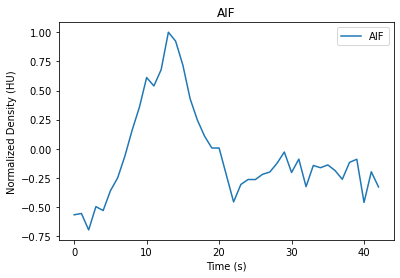

In [52]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(label)
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [53]:

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [54]:
train_features, train_labels = next(iter(train_dataloader))
train_labels.shape


torch.Size([1, 43])

In [55]:
train_features.shape

torch.Size([1, 43, 2, 256, 256])

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
# Define model
class AIFNet(nn.Module):
    def __init__(self):
        super(AIFNet, self).__init__()
        
        self.firstConv3d  = self._conv3d_relu(in_c=43, out_c=16, k_size=(1,3,3),pad_size=(0,1,1))
        self.secondConv3d = self._conv3d_relu(in_c=16, out_c=32, k_size=(1,3,3),pad_size=(0,1,1))
        self.thirdConv3d  = self._conv3d_relu(in_c=32, out_c=64, k_size=(1,3,3),pad_size=(0,1,1))
        self.fourthConv3d = self._conv3d_relu(in_c=64, out_c=128, k_size=(1,3,3),pad_size=(0,1,1))
        self.Lout         = self._conv3d_relu(in_c=128, out_c=1, k_size=(1,3,3),pad_size=(0,1,1))
        self.softmax3d    = torch.nn.Softmax(dim=0)
        
    def _conv3d_relu(self, in_c, out_c, k_size,pad_size=0):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=k_size,padding=pad_size,padding_mode='zeros'),
            nn.ReLU()
        )
        return conv_layer        
    def forward(self, input_x):
        x = self.firstConv3d(input_x)
        x = self.secondConv3d(x)
        x = self.thirdConv3d(x)
        x = self.fourthConv3d(x)
        x = self.Lout(x)
        pvol_shape = x.shape
        Pvol = self.softmax3d(x.flatten())
        Pvol = Pvol.reshape(pvol_shape)
        voxelwise_mult = torch.mul(Pvol,input_x)
        #print(voxelwise_mult.sum())
        aif_hat = voxelwise_mult.mean(dim=(-3,-2,-1)) #This should be [N,TimePoints]
        return aif_hat

model = AIFNet().to(device)
print(model)


Using cpu device
AIFNet(
  (firstConv3d): Sequential(
    (0): Conv3d(43, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (secondConv3d): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (thirdConv3d): Sequential(
    (0): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (fourthConv3d): Sequential(
    (0): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (Lout): Sequential(
    (0): Conv3d(128, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (softmax3d): Softmax(dim=0)
)


In [57]:
a = torch.tensor(np.array([[[1,2],[3,4]],[[5,5],[5,5]]]))
a = a[np.newaxis,:,:]
b = torch.tensor([[5,6],[7,8]])

torch.mul(a,b)

tensor([[[[ 5, 12],
          [21, 32]],

         [[25, 30],
          [35, 40]]]])

In [58]:
# With square kernels and equal stride
#m =nn.Conv3d(in_channels=43, out_channels=16, kernel_size=1)#43 volumes enter, 16 out, 1x1 kernels, stride=1 (First layer)
model.double()

# non-square kernels and unequal stride and with padding
#m = nn.Conv3d(16, 33, (3, 5, 2), stride=(2, 1, 1), padding=(4, 2, 0))

output = model(train_features)


In [59]:
print(output.shape)
print(train_features.shape)
train_labels

torch.Size([1, 43])
torch.Size([1, 43, 2, 256, 256])


tensor([[11.5773, 12.1581, 11.6403, 10.5578,  9.4467,  8.3940,  6.6639,  4.8633,
          3.7224,  2.2473,  1.1608,  1.0000,  2.5059,  2.8312,  3.9113,  5.2378,
          5.8599,  6.4232,  7.2507,  8.2563,  9.2514,  8.9283,  9.1903,  9.6573,
          9.1662,  9.4077,  9.6297,  9.7949, 10.0343, 10.1763,  9.7528,  9.1360,
          9.5529,  9.9793,  9.8299,  9.4477, 10.2822, 10.2747, 10.0379,  9.8312,
         10.1250,  9.4997,  9.0974]], dtype=torch.float64)

In [60]:
output.sum()

tensor(1.1201e-06, dtype=torch.float64, grad_fn=<SumBackward0>)

In [61]:
def get_Pvol(input_sequence, model):
    return_layers = {'Lout': 'Lout'}
    mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
    mid_outputs, model_output = mid_getter(input_sequence)
    Pvol = mid_outputs['Lout']
    pvol_shape = Pvol.shape
    Pvol = model.softmax3d(Pvol.flatten())
    Pvol = Pvol.reshape(pvol_shape)
    return Pvol

In [62]:
train_features.shape

torch.Size([1, 43, 2, 256, 256])

In [63]:
learning_rate = 1e-3
batch_size = 1
epochs = 1
# Initialize the loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [64]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            break


In [67]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for cycle in range(10):
            for X, y in dataloader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [68]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    #test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.155148  [    0/  107]
Done!


In [ ]:
valid_preds = []
with torch.no_grad():
    for X, y in valid_data:
        #print(X.shape)
        pred = model(torch.tensor(X[np.newaxis,:,:,:,:]))
        valid_preds.append([y,pred])


In [62]:
valid_preds[0][1]

tensor([[0.0054, 0.0053, 0.0053, 0.0053, 0.0054, 0.0054, 0.0054, 0.0054, 0.0054,
         0.0054, 0.0054, 0.0053, 0.0053, 0.0054, 0.0054, 0.0054, 0.0054, 0.0055,
         0.0055, 0.0054, 0.0054, 0.0055, 0.0055, 0.0054, 0.0054, 0.0054, 0.0055,
         0.0054, 0.0053, 0.0054, 0.0054, 0.0055, 0.0059, 0.0042, 0.0054, 0.0059,
         0.0056, 0.0061, 0.0060, 0.0059, 0.0058, 0.0059, 0.0059]],
       dtype=torch.float64)

Text(0, 0.5, 'Normalized Density (HU)')

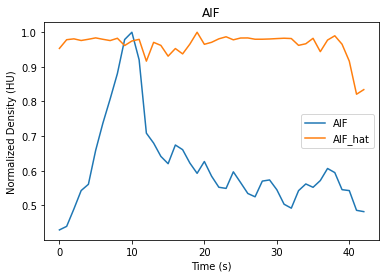

In [56]:
sample_idx = 4
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)

plt.plot(normalize_aif(valid_preds[sample_idx][0]))
plt.plot(normalize_aif(valid_preds[sample_idx][1].numpy())[0])

plt.legend([ 'AIF','AIF_hat'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [52]:
normalize_aif(valid_preds[sample_idx][1].numpy())[0]

array([0.95205994, 0.94335405, 0.95016906, 0.95873601, 0.9537691 ,
       0.96725428, 0.96629755, 0.96191469, 0.96835223, 0.96803201,
       0.97079982, 0.97320664, 0.96969335, 0.98045003, 0.96834394,
       0.95039836, 0.95767204, 0.98611424, 0.99729779, 0.99623051,
       0.99755492, 0.99797258, 0.99737665, 0.99612633, 0.99498704,
       0.99778147, 0.99751624, 0.99541864, 0.99672068, 0.99804736,
       0.99685838, 0.99462893, 0.99687561, 0.99497459, 0.98653463,
       0.97899288, 1.        , 0.99962353, 0.99520948, 0.99193547,
       0.99485979, 0.99560729, 0.99537961])

In [53]:
valid_preds[sample_idx][1].numpy()[0]

array([0.0128047 , 0.01268761, 0.01277927, 0.01289449, 0.01282768,
       0.01300905, 0.01299619, 0.01293724, 0.01302382, 0.01301951,
       0.01305674, 0.01308911, 0.01304186, 0.01318653, 0.01302371,
       0.01278235, 0.01288018, 0.01326271, 0.01341312, 0.01339877,
       0.01341658, 0.0134222 , 0.01341418, 0.01339737, 0.01338204,
       0.01341963, 0.01341606, 0.01338785, 0.01340536, 0.0134232 ,
       0.01340721, 0.01337723, 0.01340744, 0.01338188, 0.01326836,
       0.01316693, 0.01344947, 0.0134444 , 0.01338504, 0.013341  ,
       0.01338033, 0.01339039, 0.01338732])

In [54]:
valid_preds[sample_idx][0]

array([0.20188263, 0.31752041, 0.42195821, 0.53788482, 0.69063893,
       0.78223775, 0.87189056, 0.94937348, 1.        , 0.93182867,
       0.88199293, 0.79498755, 0.58071393, 0.60610943, 0.56413464,
       0.47192292, 0.38287718, 0.36688813, 0.34051685, 0.3158651 ,
       0.32887061, 0.30464745, 0.30497102, 0.31573281, 0.29265698,
       0.30907302, 0.31910397, 0.315113  , 0.2922043 , 0.31013552,
       0.33028771, 0.34305025, 0.33781572, 0.33217971, 0.32876421,
       0.33108856, 0.35012284, 0.36121016, 0.34300949, 0.30543805,
       0.30870155, 0.32944754, 0.3295981 ])